In [1]:
import category_encoders as ce
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy
import pandas as pd
import seaborn as sns
import scipy.optimize
import string
import os
from os import listdir
from os.path import isfile, join

In [15]:
action = str('walking, jogging, stairs, sitting, standing, typing, brushing teeth, eathing soup, eating chips, eating pasta, drinking from cup, eating sandwitch, soccer, tennis, basketball, writing, clapping, folding clothes')
l = [n.lstrip() for n in action.split(",")]
alpha = [n for n in string.ascii_uppercase[:19]]
alpha.remove('N')
dict_action = {k:v for k,v in zip(alpha,l)}

# Feature Engineering

Each data file contains 6 columns, Id, Activity, Timestamp, X, Y, Z. The directory is split into 4 sets from the two sensor, phone and watch, and inside contains either gyro or acceleration x y z data. Each data point in the datafile is captured at a rate of 50ms. 
<br>
For feature engineering only the x y and z component is used. From there we are extracting the following:
<br>
X Y Z avg (3)
<br>
X Y Z std (3)
<br>
X Y Z var (3)
<br>
X Y Z abs range (3)
<br>
XYZ resultant (1)
<br>
Bin distributions of 10 for each axis totaling 30 features for x y z (30)
<br>
X Y Z sine fitted period (3)
<br>
<br>
Total of 46 features are used to predict the activity of the user.


In [3]:
os.getcwd()

'C:\\Users\\kai_t\\000001 Jupyter\\wisdm\\project'

In [3]:
phone_gyro = 'C:\\Users\\kai_t\\000001 Jupyter\\wisdm\\wisdm-dataset\\wisdm-dataset\\raw\\phone\\gyro'
phone_accel = 'C:\\Users\\kai_t\\000001 Jupyter\\wisdm\\wisdm-dataset\\wisdm-dataset\\raw\\phone\\accel'
watch_gyro = 'C:\\Users\\kai_t\\000001 Jupyter\\wisdm\\wisdm-dataset\\wisdm-dataset\\raw\\watch\\gyro'
watch_accel = 'C:\\Users\\kai_t\\000001 Jupyter\\wisdm\\wisdm-dataset\\wisdm-dataset\\raw\\watch\\accel'

paths = [phone_accel, phone_gyro, watch_accel, watch_gyro]

file_list = [[f for f in listdir(n) if isfile(join(n, f))] for n in paths]
onlyfiles = [item for items in file_list for item in items[1:]]

In [4]:
li = ['x', 'y', 'z']
column_list = []
for n in li:
    column_list.append(f'{n}_avg'.format(n))
for n in li:
    column_list.append(f'{n}_std'.format(n))
for n in li:
    column_list.append(f'{n}_var'.format(n))
for n in li:
    column_list.append(f'{n}_min'.format(n))
for n in li:
    column_list.append(f'{n}_range'.format(n))        

In [9]:
class part_df():

    
    timing = 1000 # 200 for 10s, 1000 for 50s, 50ms per point
    
    def __init__(self, df):
        self.df = df
        self.dfx = pd.DataFrame()
    
    def avg_(self, info):
        return pd.Series((info.loc['mean'][['x', 'y', 'z']]).values, index = column_list[:3])

    def std_(self, info):
        return pd.Series((info.loc['std'][['x', 'y', 'z']]).values, index = column_list[3:6])

    def var_(self, df):
        return pd.Series([df[xyz].var() for xyz in ['x', 'y', 'z']], index = column_list[6:9])

    def min_(self, info):
        return pd.Series((info.loc['min'][['x', 'y', 'z']]).values, index = column_list[9:12])

    def rangee_(self, info):
        return pd.Series((abs(info.loc['max'][['x', 'y', 'z']] - info.loc['min'][['x', 'y', 'z']])).values, 
                         index = column_list[12:15])

    def resultant_(self, df):
        return pd.Series((((df[['x', 'y', 'z']]**2).sum(axis=1))**(1/2)).mean(),
                         index = ['resultant'])
    
    def dummies(self, df, info):
        ranges = abs(info.loc['max']-info.loc['min'])
        dums = pd.DataFrame()
    
        for xyz in ['x', 'y', 'z']:
            rang = [(((ranges[xyz]/10) * n) + info.loc['min'][xyz]) for n in range(1,10)]
            l = np.digitize(df[xyz], rang, right=False)
            dums = pd.DataFrame(pd.concat([dums, pd.get_dummies(l, prefix = xyz).sum()/len(l)], axis =0, sort=False))
        return dums.transpose()
        
    def action(self):
        act_list = list(self.df.activity.unique())
        for act in act_list:
            dfn = self.df[self.df.activity == act]
            idd = self.df['id'][0]
            for lenn in range(int(len(dfn)/self.timing)):
                dfn1 = dfn.iloc[((lenn)*self.timing):((lenn+1)*self.timing)]
                info = dfn1.describe()
                dfp = pd.DataFrame(pd.concat([self.avg_(info), self.std_(info), self.min_(info), self.rangee_(info),
                                              self.var_(dfn1), self.resultant_(dfn1), 
                                              pd.Series(act, index = ['activity']), pd.Series(idd, index = ['id'])], axis = 0  
                                    ))
                dfp = pd.concat([self.dummies(dfn1, info), dfp.transpose()], axis = 1 ,sort=False)
                self.dfx= pd.concat([self.dfx, dfp], axis = 0, sort=False)
            
        return self.dfx

In [6]:
class sine():
    
    timing = 1000 # 200 for 10s, 1000 for 50s, 50ms per point
    timerange = [n for n in range(1000)] # 200 for 10s, 1000 for 50s
    
    def __init__(self, df):
        self.df = df
        self.dfx = pd.DataFrame(columns=['xpeak', 'ypeak', 'zpeak'])
        self.period = []
        
    def fit_sin(self, tt, yy):
        '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
        tt = numpy.array(tt)
        yy = numpy.array(yy)
        ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
        Fyy = abs(numpy.fft.fft(yy))
        guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
        guess_amp = numpy.std(yy) * 2.**0.5
        guess_offset = numpy.mean(yy)
        guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

        def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
        try:
            popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
            A, w, p, c = popt
            f = w/(2.*numpy.pi)
            fitfunc = lambda t: A * numpy.sin(w*t + p) + c
            return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}
        except:
            return {'period':999999}
        
        
    def action(self):
        act_list = list(self.df.activity.unique())
        for act in act_list:
            dfn = self.df[self.df.activity == act]
            for lenn in range(int(len(dfn)/self.timing)):
                dfn1 = dfn.iloc[((lenn)*self.timing):((lenn+1)*self.timing)]
                period = pd.Series([self.fit_sin(self.timerange, dfn1[xyz])['period'] for xyz in ['x', 'y', 'z']], index=['xpeak', 'ypeak', 'zpeak'])
                self.dfx = self.dfx.append(period, ignore_index = True)
        
        return self.dfx
            

In [13]:
# Too lazy to run this again throughout the data. There are two cycling def runs, first one is using x=part_df()
# and the second is using x = sin() to get the period of the fitted sine wave


# def cycling(folder):
#     df1 = pd.DataFrame()
#     for dirr in folder:
#         file_list = [f for f in listdir(dirr) if isfile(join(dirr, f))][1:]
#         for file in file_list:
#             print(file)
#             dfq = pd.read_csv(dirr + '\\' + file , names = ['id', 'activity', 'timestamp', 'x', 'y', 'z'])
#             dfq['z'] = list([np.float(n.split(';')[0]) for n in dfq['z']])
#             x = part_df(dfq)
#             dfxx = x.action()
#             df1 = pd.concat([df1, dfxx], axis = 0, sort = False)
        
#     return df1.reset_index(drop=True)

def cycling(folder):
    df1 = pd.DataFrame()
    for dirr in folder:
        file_list = [f for f in listdir(dirr) if isfile(join(dirr, f))][1:]
        for file in file_list:
            print(file)
            dfq = pd.read_csv(dirr + '\\' + file , names = ['id', 'activity', 'timestamp', 'x', 'y', 'z'])
            dfq['z'] = list([np.float(n.split(';')[0]) for n in dfq['z']])
            x = sine(dfq)
            dfxx = x.action()
            df1 = pd.concat([df1, dfxx], axis = 0, sort = False)
        
    return df1.reset_index(drop=True)


# loading all the DF
# df = pd.DataFrame()
# for path_accel in paths:
#     for accel in onlyfiles:
#         dfq = pd.read_csv(path_accel + '\\' + accel, names = ['id', 'activity', 'timestamp', 'x', 'y', 'z'])
#         dfq['z'] = list([np.float(n.split(';')[0]) for n in dfq['z']])
#         df = pd.concat([df, dfq])

In [188]:
# df1 = pd.read_csv('C:\\Users\\kai_t\\000001 Jupyter\\wisdm\\wisdm-dataset\\wisdm-dataset\\raw\\watch\\accel\\data_1614_accel_watch.txt',names = ['id', 'activity', 'timestamp', 'x', 'y', 'z'])
# df1['z'] = list([np.float(n.split(';')[0]) for n in df1['z']])

In [20]:
# x.to_csv('C:\\Users\\kai_t\\000001 Jupyter\\wisdm\\project\\phonewatchdata1000.csv', index = False)

# Modeling Start here

In [2]:
x = pd.read_csv('C:\\Users\\kai_t\\000001 Jupyter\\wisdm\\project\\phonewatchdata.csv')

In [13]:
x.drop(['x_min','y_min','z_min'], axis=1,inplace=True)

In [14]:
x.loc[:,x.columns[-3:]] = x.loc[:,x.columns[-3:]]/50

In [12]:
x.fillna(99999, inplace=True)

In [17]:
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x_0,8547.0,0.014757,0.041281,1.000000e-03,0.002000,0.005000,0.011000,0.875000
x_1,8547.0,0.035698,0.069412,1.000000e-03,0.005000,0.012000,0.035000,0.921000
x_2,8547.0,0.073428,0.099009,1.000000e-03,0.014000,0.038000,0.095000,0.924000
x_3,8547.0,0.145379,0.152511,1.000000e-03,0.039000,0.100000,0.190000,0.958000
x_4,8547.0,0.225165,0.181642,1.000000e-03,0.089000,0.183000,0.311000,0.952000
x_5,8547.0,0.226321,0.179105,1.000000e-03,0.090000,0.190000,0.318000,0.956000
x_6,8547.0,0.147330,0.148961,1.000000e-03,0.040000,0.106000,0.201000,0.968000
x_7,8547.0,0.076018,0.102148,1.000000e-03,0.014000,0.040000,0.097000,0.953000
x_8,8547.0,0.036514,0.069179,1.000000e-03,0.005000,0.013000,0.037000,0.934000
x_9,8547.0,0.019391,0.052365,1.000000e-03,0.002000,0.005000,0.011000,0.905000


In [11]:
len(x)

76630

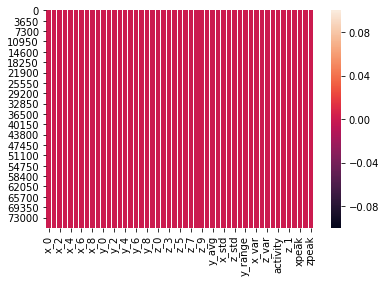

In [9]:
sns.heatmap(x.isnull())

In [5]:
x['act_id'] = x.activity.factorize()[0]
cat_id_df = x[['act_id', 'activity']].drop_duplicates().sort_values('act_id')
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['activity', 'act_id']].values)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, r2_score
from sklearn.utils import shuffle

In [7]:
x = shuffle(x)

# Accel Data

In [8]:
clf = RandomForestClassifier(n_estimators=10)
CV = 5
X = x[(x.sensor == 'accel_phone') | (x.sensor == 'accel_watch' )].drop(['sensor','activity', 'id'], axis=1)
y = x[(x.sensor == 'accel_phone') | (x.sensor == 'accel_watch' )]['act_id']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Random Forest

In [ ]:
accuracies = cross_val_score(clf, X, y, scoring='accuracy', cv=CV)
accuracies

In [ ]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print(classification_report(y_test, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

## Cross val predict

In [18]:
result = cross_val_predict(clf, X, y, cv=10)
print(classification_report(y, result, target_names= list(map(dict_action.get , x['activity'].unique())) ))

                   precision    recall  f1-score   support

drinking from cup       0.99      1.00      0.99      2412
       basketball       0.99      0.99      0.99      2334
           stairs       0.93      0.99      0.96      2275
          jogging       0.93      0.94      0.93      2348
           soccer       0.91      0.93      0.92      2391
     eating chips       0.89      0.94      0.91      2220
     eathing soup       0.85      0.89      0.87      2353
     eating pasta       0.80      0.84      0.82      2362
  folding clothes       0.77      0.78      0.78      2318
          walking       0.80      0.78      0.79      2226
 eating sandwitch       0.83      0.79      0.81      2466
           tennis       0.84      0.75      0.79      2307
          writing       0.90      0.95      0.92      2402
   brushing teeth       0.88      0.91      0.90      2372
         clapping       0.93      0.88      0.90      2388
          sitting       0.94      0.89      0.91      2

# Gyro Data

In [23]:
clf = RandomForestClassifier(n_estimators=10)
CV = 5
X = x.drop(['sensor', 'activity'], axis=1)
y = x['act_id']

In [20]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print(classification_report(y_test, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

                   precision    recall  f1-score   support

drinking from cup       1.00      1.00      1.00       993
       basketball       0.99      0.99      0.99       919
           stairs       0.95      0.98      0.97       914
          jogging       0.92      0.93      0.93       944
           soccer       0.86      0.91      0.88       970
     eating chips       0.84      0.92      0.88       879
     eathing soup       0.80      0.85      0.82       930
     eating pasta       0.73      0.79      0.76       945
  folding clothes       0.70      0.71      0.70       933
          walking       0.74      0.68      0.71       881
 eating sandwitch       0.75      0.73      0.74       996
           tennis       0.74      0.65      0.69       915
          writing       0.89      0.95      0.92       969
   brushing teeth       0.90      0.90      0.90       929
         clapping       0.92      0.88      0.90       969
          sitting       0.90      0.83      0.86       

## Cross val predict

In [21]:
result = cross_val_predict(clf, X, y, cv=10)
print(classification_report(y, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

                   precision    recall  f1-score   support

drinking from cup       0.97      0.99      0.98      1938
       basketball       0.97      0.99      0.98      1897
           stairs       0.87      0.95      0.91      1849
          jogging       0.87      0.91      0.89      1939
           soccer       0.83      0.88      0.85      1936
     eating chips       0.80      0.89      0.84      1864
     eathing soup       0.82      0.81      0.82      1922
     eating pasta       0.69      0.74      0.71      1903
  folding clothes       0.67      0.68      0.67      1904
          walking       0.71      0.68      0.70      1891
 eating sandwitch       0.73      0.71      0.72      1958
           tennis       0.72      0.61      0.66      1896
          writing       0.82      0.90      0.86      1925
   brushing teeth       0.87      0.86      0.86      1888
         clapping       0.91      0.84      0.88      1939
          sitting       0.88      0.82      0.85      1

## Whole DF

In [13]:
clf = RandomForestClassifier(n_estimators=10)
CV = 5
X = x.drop(['sensor', 'activity'], axis=1)
y = x['act_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print(classification_report(y_test, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

                   precision    recall  f1-score   support

           soccer       0.99      1.00      1.00      1364
         clapping       0.99      0.99      0.99      1283
       basketball       0.93      0.98      0.95      1252
           stairs       0.95      0.94      0.95      1297
          jogging       0.94      0.92      0.93      1308
     eating chips       0.89      0.94      0.91      1235
 eating sandwitch       0.84      0.87      0.86      1282
           typing       0.77      0.82      0.79      1236
     eathing soup       0.72      0.76      0.74      1237
          walking       0.78      0.75      0.76      1218
          sitting       0.84      0.79      0.81      1315
     eating pasta       0.84      0.76      0.80      1229
          writing       0.84      0.92      0.88      1316
drinking from cup       0.90      0.87      0.88      1334
  folding clothes       0.93      0.88      0.90      1307
   brushing teeth       0.96      0.94      0.95      1

In [24]:
result = cross_val_predict(clf, X, y, cv=10)
print(classification_report(y, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

                   precision    recall  f1-score   support

drinking from cup       0.99      1.00      0.99      4350
       basketball       0.99      0.99      0.99      4231
           stairs       0.92      0.98      0.95      4124
          jogging       0.91      0.93      0.92      4287
           soccer       0.88      0.91      0.89      4327
     eating chips       0.87      0.93      0.90      4084
     eathing soup       0.85      0.87      0.86      4275
     eating pasta       0.77      0.82      0.79      4265
  folding clothes       0.74      0.76      0.75      4222
          walking       0.79      0.76      0.77      4117
 eating sandwitch       0.82      0.79      0.81      4424
           tennis       0.80      0.71      0.76      4203
          writing       0.89      0.94      0.91      4327
   brushing teeth       0.89      0.90      0.89      4260
         clapping       0.93      0.88      0.91      4327
          sitting       0.91      0.86      0.89      4

# XGB

In [25]:
from xgboost import XGBClassifier

In [26]:
clf = XGBClassifier()

## Accel data

In [27]:
CV = 10
X = x[(x.sensor == 'accel_phone') | (x.sensor == 'accel_watch' )].drop(['sensor','activity'], axis=1)
y = x[(x.sensor == 'accel_phone') | (x.sensor == 'accel_watch' )]['act_id']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [29]:
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print(classification_report(y_test, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

                   precision    recall  f1-score   support

drinking from cup       1.00      1.00      1.00       993
       basketball       1.00      1.00      1.00       919
           stairs       1.00      1.00      1.00       914
          jogging       1.00      1.00      1.00       944
           soccer       1.00      1.00      1.00       970
     eating chips       1.00      1.00      1.00       879
     eathing soup       1.00      1.00      1.00       930
     eating pasta       1.00      1.00      1.00       945
  folding clothes       1.00      1.00      1.00       933
          walking       1.00      1.00      1.00       881
 eating sandwitch       1.00      1.00      1.00       996
           tennis       1.00      1.00      1.00       915
          writing       1.00      1.00      1.00       969
   brushing teeth       1.00      1.00      1.00       929
         clapping       1.00      1.00      1.00       969
          sitting       1.00      1.00      1.00       

In [30]:
result = cross_val_predict(clf, X, y, cv=5)
print(classification_report(y, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

                   precision    recall  f1-score   support

drinking from cup       1.00      1.00      1.00      2412
       basketball       1.00      1.00      1.00      2334
           stairs       1.00      1.00      1.00      2275
          jogging       1.00      1.00      1.00      2348
           soccer       1.00      1.00      1.00      2391
     eating chips       1.00      1.00      1.00      2220
     eathing soup       1.00      1.00      1.00      2353
     eating pasta       1.00      1.00      1.00      2362
  folding clothes       1.00      1.00      1.00      2318
          walking       1.00      1.00      1.00      2226
 eating sandwitch       1.00      1.00      1.00      2466
           tennis       1.00      1.00      1.00      2307
          writing       1.00      1.00      1.00      2402
   brushing teeth       1.00      1.00      1.00      2372
         clapping       1.00      1.00      1.00      2388
          sitting       1.00      1.00      1.00      2

## Gyro Data

In [31]:
CV = 5
X = x[(x.sensor == 'gyro_phone') | (x.sensor == 'gyro_watch' )].drop(['sensor','activity'], axis=1)
y = x[(x.sensor == 'gyro_phone') | (x.sensor == 'gyro_watch' )]['act_id']

In [32]:
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print(classification_report(y_test, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

                   precision    recall  f1-score   support

drinking from cup       1.00      1.00      1.00       993
       basketball       1.00      1.00      1.00       919
           stairs       1.00      1.00      1.00       914
          jogging       1.00      1.00      1.00       944
           soccer       1.00      1.00      1.00       970
     eating chips       1.00      1.00      1.00       879
     eathing soup       1.00      1.00      1.00       930
     eating pasta       1.00      1.00      1.00       945
  folding clothes       1.00      1.00      1.00       933
          walking       1.00      1.00      1.00       881
 eating sandwitch       1.00      1.00      1.00       996
           tennis       1.00      1.00      1.00       915
          writing       1.00      1.00      1.00       969
   brushing teeth       1.00      1.00      1.00       929
         clapping       1.00      1.00      1.00       969
          sitting       1.00      1.00      1.00       

## Whole DF

In [33]:
CV = 5
X = x.drop(['sensor','activity'], axis=1)
y = x['act_id']

In [34]:
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print(classification_report(y_test, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

                   precision    recall  f1-score   support

drinking from cup       1.00      1.00      1.00       993
       basketball       1.00      1.00      1.00       919
           stairs       1.00      1.00      1.00       914
          jogging       1.00      1.00      1.00       944
           soccer       1.00      1.00      1.00       970
     eating chips       1.00      1.00      1.00       879
     eathing soup       1.00      1.00      1.00       930
     eating pasta       1.00      1.00      1.00       945
  folding clothes       1.00      1.00      1.00       933
          walking       1.00      1.00      1.00       881
 eating sandwitch       1.00      1.00      1.00       996
           tennis       1.00      1.00      1.00       915
          writing       1.00      1.00      1.00       969
   brushing teeth       1.00      1.00      1.00       929
         clapping       1.00      1.00      1.00       969
          sitting       1.00      1.00      1.00       

# KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [36]:
clf = KNeighborsClassifier(n_neighbors=18)

# Whole DF

In [37]:
X = x.drop(['sensor','activity'], axis=1)
y = x['act_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [38]:
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print(classification_report(y_test, result, target_names= list(map(dict_action.get , x['activity'].unique()))))

                   precision    recall  f1-score   support

drinking from cup       0.70      0.74      0.72      1766
       basketball       0.85      0.80      0.82      1693
           stairs       0.55      0.52      0.53      1653
          jogging       0.31      0.36      0.33      1719
           soccer       0.36      0.44      0.40      1696
     eating chips       0.36      0.46      0.41      1641
     eathing soup       0.60      0.57      0.58      1663
     eating pasta       0.40      0.44      0.42      1691
  folding clothes       0.31      0.33      0.32      1644
          walking       0.39      0.37      0.38      1614
 eating sandwitch       0.38      0.39      0.38      1789
           tennis       0.37      0.29      0.33      1705
          writing       0.45      0.61      0.52      1729
   brushing teeth       0.42      0.38      0.40      1694
         clapping       0.52      0.45      0.48      1728
          sitting       0.39      0.33      0.36      1